In [ ]:
# Basic libraries
import numpy as np
import pandas as pd

## NLP libraries
import re
import string
import nltk
from nltk.corpus import stopwords

## ML Libraries
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

## Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap
from scipy.stats import chi2_contingency
from subprocess import check_output

#Keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


In [ ]:
data_url = 'https://www.math.unipd.it/~dasan/disaster/'
train_csv = pd.read_csv(data_url + 'train.csv', sep=",") 
test_csv = pd.read_csv(data_url + 'test.csv', sep=",") 

 **Understanding Data**

In [ ]:
# let's take a look at the data
display(train_csv.head())
display(test_csv.head())

Y_train = train_csv['target'].values
X_train = train_csv.values[:, 1:4] # extracting the columns keyword, location and text (without id)

# let's print one example to check we picked the right columns
print(X_train[0])

X_test_text = test_csv['text']
X_test_id = test_csv['id'].values
# these are needed to build output prediction files if you want to submit your predictions to the Kaggle website (see format of the submission)

print(Y_train.shape, X_test_id.shape, X_train.shape)

# create a dummy pessimistic predictor that always says DISASTER (class 1) 
test_predictions = np.ones((len(X_test_id),1), dtype=int)

# download_predictions_to_file(X_test_id, test_predictions) # download the prediction file


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


[nan nan
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all']
(7613,) (3263,) (7613, 3)


In [ ]:
train_csv.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test_csv.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

**Check number of unique keywords, and whether they are the same for train and test sets**

In [ ]:
print (train_csv.keyword.nunique(), test_csv.keyword.nunique())

221 221


**Most common words**

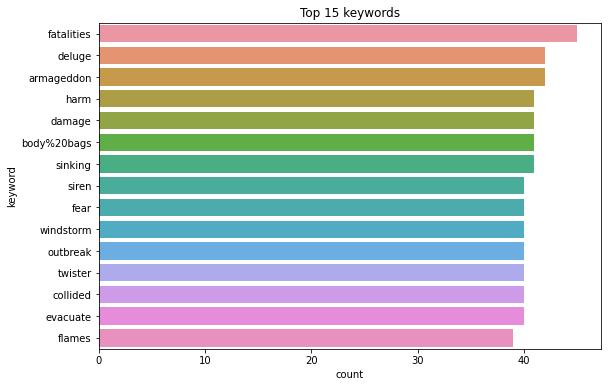

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_csv.keyword, order = train_csv.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

**Top 10 words in disaster and non-disaster tweets**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


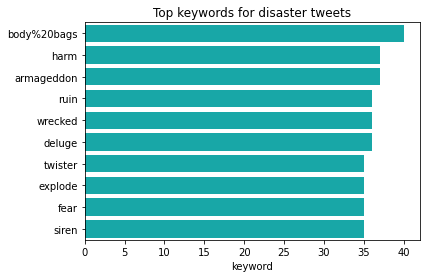

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


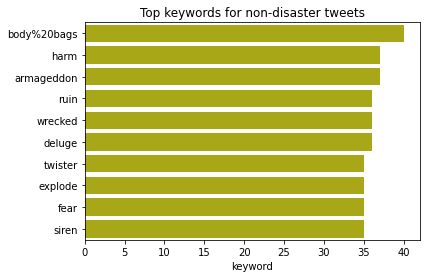

In [ ]:
kw_nd = train_csv[train_csv.target==0].keyword.value_counts().head(10)

sns.barplot(kw_nd, kw_nd.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.show()
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

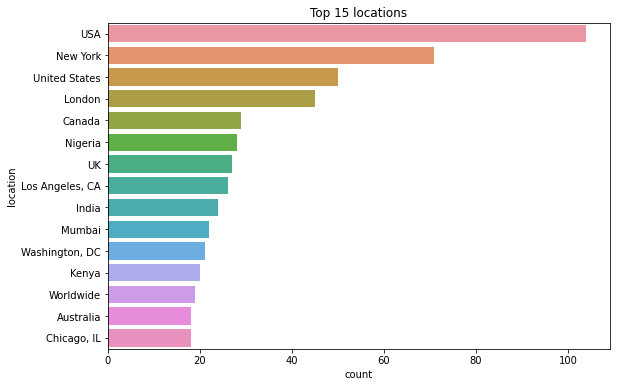

In [ ]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train_csv.location, order = train_csv.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of **disaster** tweets for common locations.

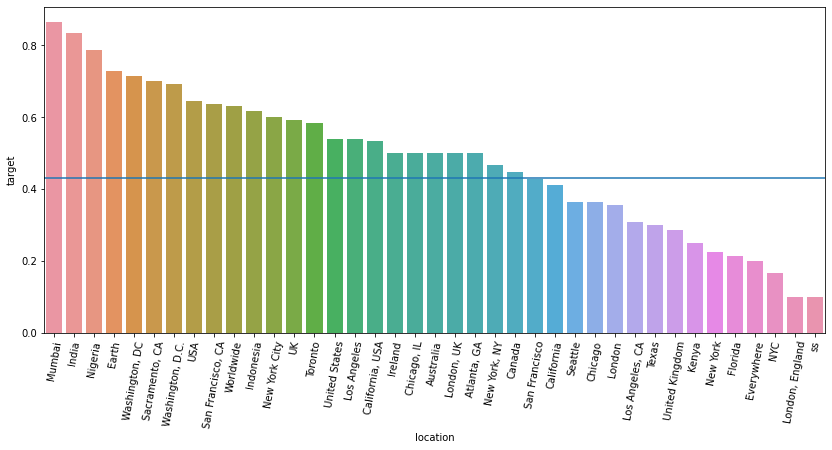

In [ ]:
raw_loc = train_csv.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train_csv[train_csv.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train_csv.target))
plt.xticks(rotation=80)
plt.show()

In [ ]:
# Samples of disaster and non-disaster tweets
display('Random sample of disaster tweets:', train_csv[train_csv.target==1].text.sample(3).to_frame())
display('Random sample of non disaster tweets:', train_csv[train_csv.target==0].text.sample(3).to_frame())

'Random sample of disaster tweets:'

,text
2418,Breakfast links: Work from home: Derailed: An ...
7115,POV video captures violent landing at Amsterda...
4553,4 dead dozens injured in Gaza blast near house...


'Random sample of non disaster tweets:'

,text
121,Aftershock: Protect Yourself and Profit in the...
4988,Mike Magner Discusses A Trust Betrayed: http:/...
133,People who say it cannot be done should not in...


In [ ]:
# Words clouds of tweets
disaster_tweets = train_csv[train_csv['target']==1]['text']
non_disaster_tweets = train_csv[train_csv['target']==0]['text']

Text(0.5, 1.0, 'Non Disaster Tweets')

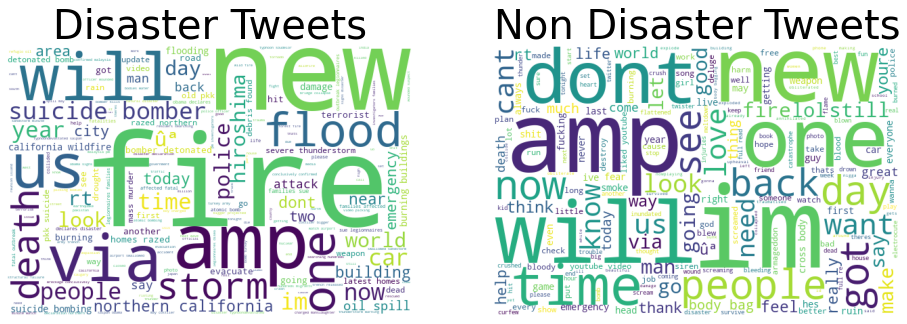

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
wordcloud1 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets', fontsize=40);

wordcloud2 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets', fontsize=40)

**Text preprocessing**

In [ ]:
# 1. Text Cleaning
# lowering the text
train_csv.text=train_csv.text.apply(lambda x:x.lower() )
test_csv.text=test_csv.text.apply(lambda x:x.lower())
# removing square brackets
train_csv.text=train_csv.text.apply(lambda x:re.sub('\[.*?\]', '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('\[.*?\]', '', x) )
train_csv.text=train_csv.text.apply(lambda x:re.sub('<.*?>+', '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('<.*?>+', '', x) )
# removing hyperlinks
train_csv.text=train_csv.text.apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x) )
# removing punctuation
train_csv.text=train_csv.text.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x) )
train_csv.text=train_csv.text.apply(lambda x:re.sub('\n' , '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('\n', '', x) )
# remove words containing numbers
train_csv.text=train_csv.text.apply(lambda x:re.sub('\w*\d\w*' , '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('\w*\d\w*', '', x) )

train_csv.text.head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
# 2. Tokenizer
token=nltk.tokenize.RegexpTokenizer(r'\w+')
# applying token
train_csv.text=train_csv.text.apply(lambda x:token.tokenize(x))
test_csv.text=test_csv.text.apply(lambda x:token.tokenize(x))
# view
display(train_csv.text.head())

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [ ]:
nltk.download('stopwords')
# 3. Removing stopwords
train_csv.text=train_csv.text.apply(lambda x:[w for w in x if w not in stopwords.words('english')])
test_csv.text=test_csv.text.apply(lambda x:[w for w in x if w not in stopwords.words('english')])
# view
train_csv.text.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [ ]:
# 4. Stemming
# stemmering the text and joining
stemmer = nltk.stem.PorterStemmer()
train_csv.text=train_csv.text.apply(lambda x:" ".join(stemmer.stem(token) for token in x))
test_csv.text=test_csv.text.apply(lambda x:" ".join(stemmer.stem(token) for token in x))
# view
train_csv.text.head()

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

**Preparing sets for the training and assessing the models**

In [ ]:
train, valid = train_test_split(train_csv, test_size=0.2)
# 0.2 - 20% tweets in valid set

In [ ]:
print(train['text'])

6276    new item pillow cover size pillow cover grey p...
5185    damnnnn gmcr got obliter pay huge whomev play ...
5659           last chanc anim rescu new post animalrescu
4600    nepdloyko texan hope wrong radio houston start...
3632    saudi arabia abha fatal report follow suicid b...
                              ...                        
6656    rt abbswinston zionist terrorist kidnap palest...
5378    lose bu cardpanickind bu driverreplac bu cardf...
7367    windstorm cover vhull runabout boat includ eur...
6329    virgin galact crash earli unlock brake trigger...
1737    cyclist collid runner roanok greenway win civi...
Name: text, Length: 6090, dtype: object


**Vectorization**

In [ ]:
# Vectorize the train, validation and test sets
count_vect = CountVectorizer()
train_set = count_vect.fit_transform(train['text']) #fit_transform only on training data
valid_set = count_vect.transform(valid['text'])
test_set = count_vect.transform(test_csv["text"])
# The fit method is calculating the mean and variance of each of the features present in our data.
# The transform method is transforming all the features using the respective mean and variance.

In [ ]:
# Preparing the data for testing the models
X_train_new = train_set
X_test_new = valid_set
y_train_new = train['target']
y_test_new = valid['target']

In [ ]:
train_set.shape

(6090, 11555)

In [ ]:
valid_set.shape

(1523, 11555)

In [ ]:
test_set.shape

(3263, 11555)

**Models**

In [ ]:
# 1. k-NN
# Let us find the appropriate number of neighbors
param_grid={'n_neighbors':np.arange(1,50)}
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn, param_grid, cv=10)
knn_cv.fit(X_test_new, y_test_new)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [ ]:
print('Tunned k-NN Parameter: {}'.format(knn_cv.best_params_))
print('Tunned k-NN Accuracy: {}'.format(knn_cv.best_score_))

Tunned k-NN Parameter: {'n_neighbors': 3}
Tunned k-NN Accuracy: 0.6336214310285518


In [ ]:
kNN_model = KNeighborsClassifier(n_neighbors=3)
kNN_model.fit(X_train_new, y_train_new)
predictions = kNN_model.predict(X_test_new)

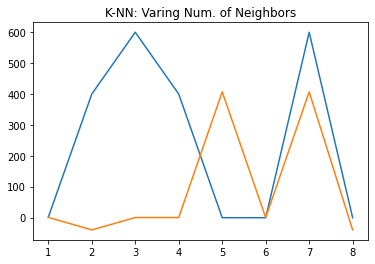

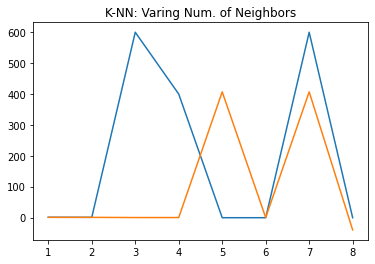

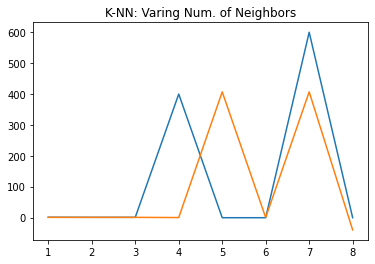

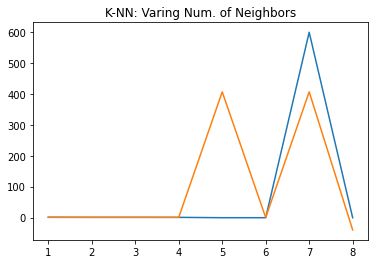

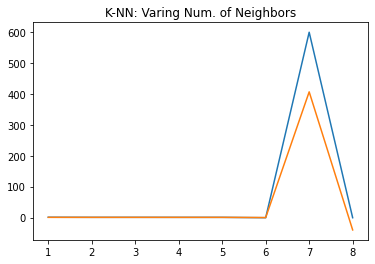

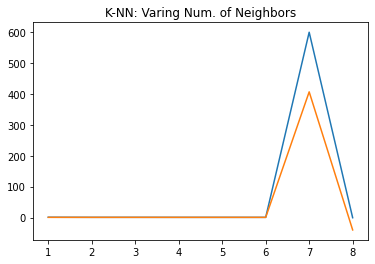

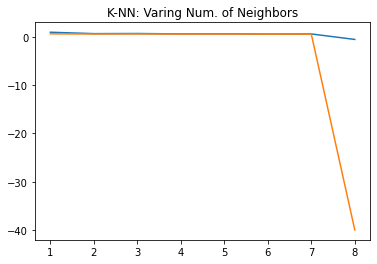

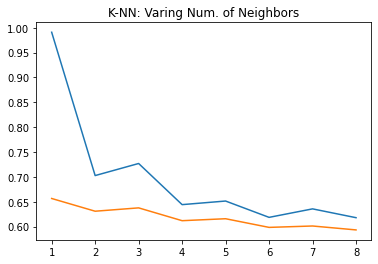

In [ ]:
nbrs=np.arange(1,9)
train_accuracy=np.empty(len(nbrs))
test_accuracy=np.empty(len(nbrs))
#Loop over different values of k
for i, k in enumerate(nbrs):
  knn=KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_test_new, y_test_new)
  train_accuracy[i]=knn.score(X_train_new, y_train_new)
  test_accuracy[i]=knn.score(X_test_new, y_test_new)
  plt.title('K-NN: Varing Num. of Neighbors')
  plt.plot(nbrs, test_accuracy, label='testing accuracy')
  plt.plot(nbrs, train_accuracy, label='training accuracy')
  plt.show()

In [ ]:
print(confusion_matrix(predictions, y_test_new))
print('*'*40)
print(classification_report(predictions, y_test_new))

[[832 388]
 [ 43 260]]
****************************************
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1220
           1       0.40      0.86      0.55       303

    accuracy                           0.72      1523
   macro avg       0.68      0.77      0.67      1523
weighted avg       0.84      0.72      0.75      1523



In [ ]:
# 2. Logistic Regression
# Logistic Regression is almost equivalent to Linear Regression. 
# The major difference between the two models is that, rather than integer values, the output of the logistic model is binary values.
c_space=np.logspace(-5,8,15)
param_grid={'C':c_space, 'penalty':['l1','l2']}
lr=LogisticRegression()
lr_cv=GridSearchCV(lr, param_grid, cv=5)
lr_cv.fit(X_train_new, y_train_new)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'penalty': ['l1', 'l2']})

In [ ]:
print('Tunned Logistic Regresion Parameter: {}'.format(lr_cv.best_params_))
print('Tunned Logistic Regresion Accuracy: {}'.format(lr_cv.best_score_))

Tunned Logistic Regresion Parameter: {'C': 0.4393970560760795, 'penalty': 'l2'}
Tunned Logistic Regresion Accuracy: 0.8014778325123153


In [ ]:
lr = LogisticRegression(C = 0.44, penalty = 'l2', random_state=42)
lr.fit(X_train_new, y_train_new)
predictions2 = lr.predict(X_test_new)

In [ ]:
print(confusion_matrix(predictions2, y_test_new))
print('*'*40)
print(classification_report(predictions2, y_test_new))

[[763 225]
 [112 423]]
****************************************
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       988
           1       0.65      0.79      0.72       535

    accuracy                           0.78      1523
   macro avg       0.76      0.78      0.77      1523
weighted avg       0.79      0.78      0.78      1523



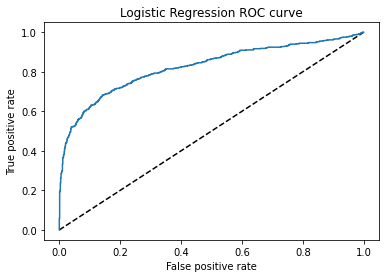

In [ ]:
y_pred_prob=lr.predict_proba(X_test_new)[:,1]
fpr, tpr, thresholds=roc_curve(y_test_new, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.show()

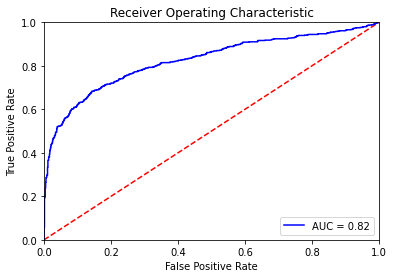

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
from sklearn import metrics
y_pred_prob=lr.predict_proba(X_test_new)[:,1]
fpr, tpr, thresholds=roc_curve(y_test_new, y_pred_prob)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
probs = lr.predict_proba(X_test_new)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_new, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# 3. Random Forest Classifier
rf = RandomForestClassifier()
param_grid = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10],
              'criterion' :['gini', 'entropy']}

rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
rf_cv.fit(X_train_new, y_train_new)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [ ]:
print('Tunned Random Forest Parameter: {}'.format(rf_cv.best_params_))
print('Tunned Random Forest Accuracy: {}'.format(rf_cv.best_score_))

Tunned Random Forest Parameter: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Tunned Random Forest Accuracy: 0.6464696223316913


In [ ]:
rf = RandomForestClassifier(criterion = 'entropy', max_depth = 10, min_samples_split = 10)
# non-tuned rf works better, 78% accuracy vs. 64%
rf.fit(X_train_new, y_train_new)
predictions3 = rf.predict(X_test_new)

In [ ]:
print(confusion_matrix(predictions3, y_test_new))
print('*'*40)
print(classification_report(predictions3, y_test_new))

[[873 542]
 [  2 106]]
****************************************
              precision    recall  f1-score   support

           0       1.00      0.62      0.76      1415
           1       0.16      0.98      0.28       108

    accuracy                           0.64      1523
   macro avg       0.58      0.80      0.52      1523
weighted avg       0.94      0.64      0.73      1523



In [ ]:
#4. Neural Network
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train_new, y_train_new)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [ ]:
prediction4=clf.predict(X_test_new)

In [ ]:
print(confusion_matrix(prediction4, y_test_new))
print('*'*40)
print(classification_report(prediction4, y_test_new))

[[815 708]
 [  0   0]]
****************************************
              precision    recall  f1-score   support

           0       1.00      0.54      0.70      1523
           1       0.00      0.00      0.00         0

    accuracy                           0.54      1523
   macro avg       0.50      0.27      0.35      1523
weighted avg       1.00      0.54      0.70      1523



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Logistic Regression and Random Forest Classifier are not so different in the results, so we chose the 1st one
lr.fit(train_set, train['target'])
predictions = lr.predict(test_set)
print(predictions)

[1 1 1 ... 1 1 0]


In [ ]:
prediction_df1 = pd.DataFrame(predictions)
frame = [test_csv['id'], prediction_df1]

result = pd.concat(frame, axis = 1)
result

,id,0
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
result.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
